# Plots for model

In [156]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
    perfs_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range
from utils.set_seed import setup_seed

import matplotlib as mpl
import matplotlib.pyplot as plt

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
# remove all edges

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

fig_dir = adapt_path("/home/wehe/data/NSC/codes/notebook/pre-figure")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
from simulator.DM_model import DM_model
from simulator.seqC_generator import seqC_generator

In [158]:
setup_seed(10)
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.8],
    seqC_sample_per_MS=1,
)
print(f"\n==>> seqC: {seqC.reshape(-1)}")


--- generated seqC info ---
dur_list: [9]
MS_list: [0.8]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)

==>> seqC: [ 0.   0.8 -0.8  0.   0.8  0.  -0.8 -0.8  0.8  nan  nan  nan  nan  nan
  nan]


mean trace

In [159]:
Lambda = -2
params = [ 1, 10, 10, Lambda]
model_name = 'B-G-L0S-O-N-'
model = DM_model(params=params, model_name=model_name)
a, probR = model.simulate(seqC.reshape(-1))
a = a[::100]
print(f"==>> probR: {probR}")

==>> probR: 0.2689312559312992


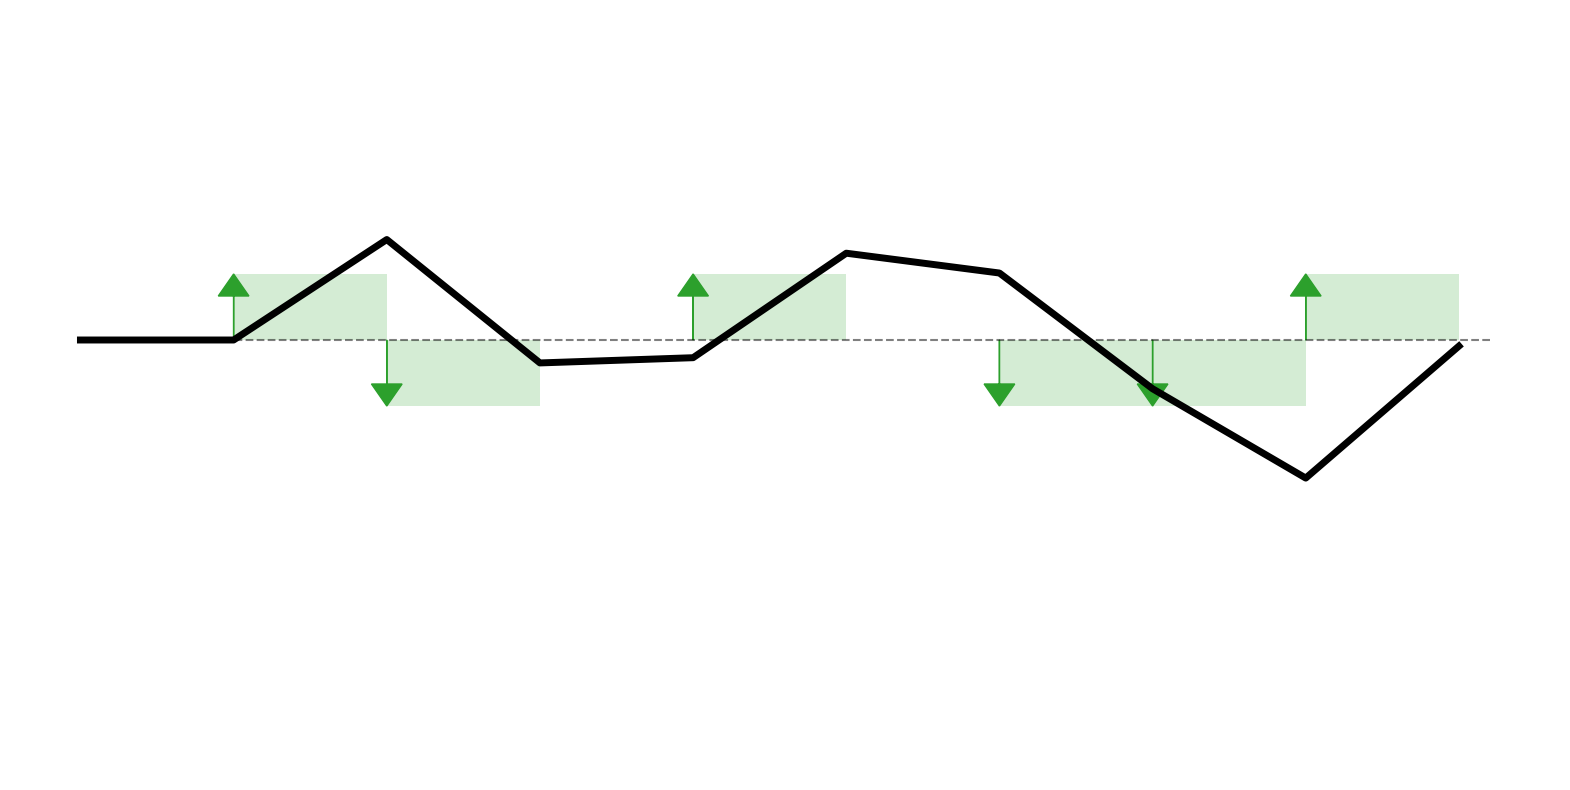

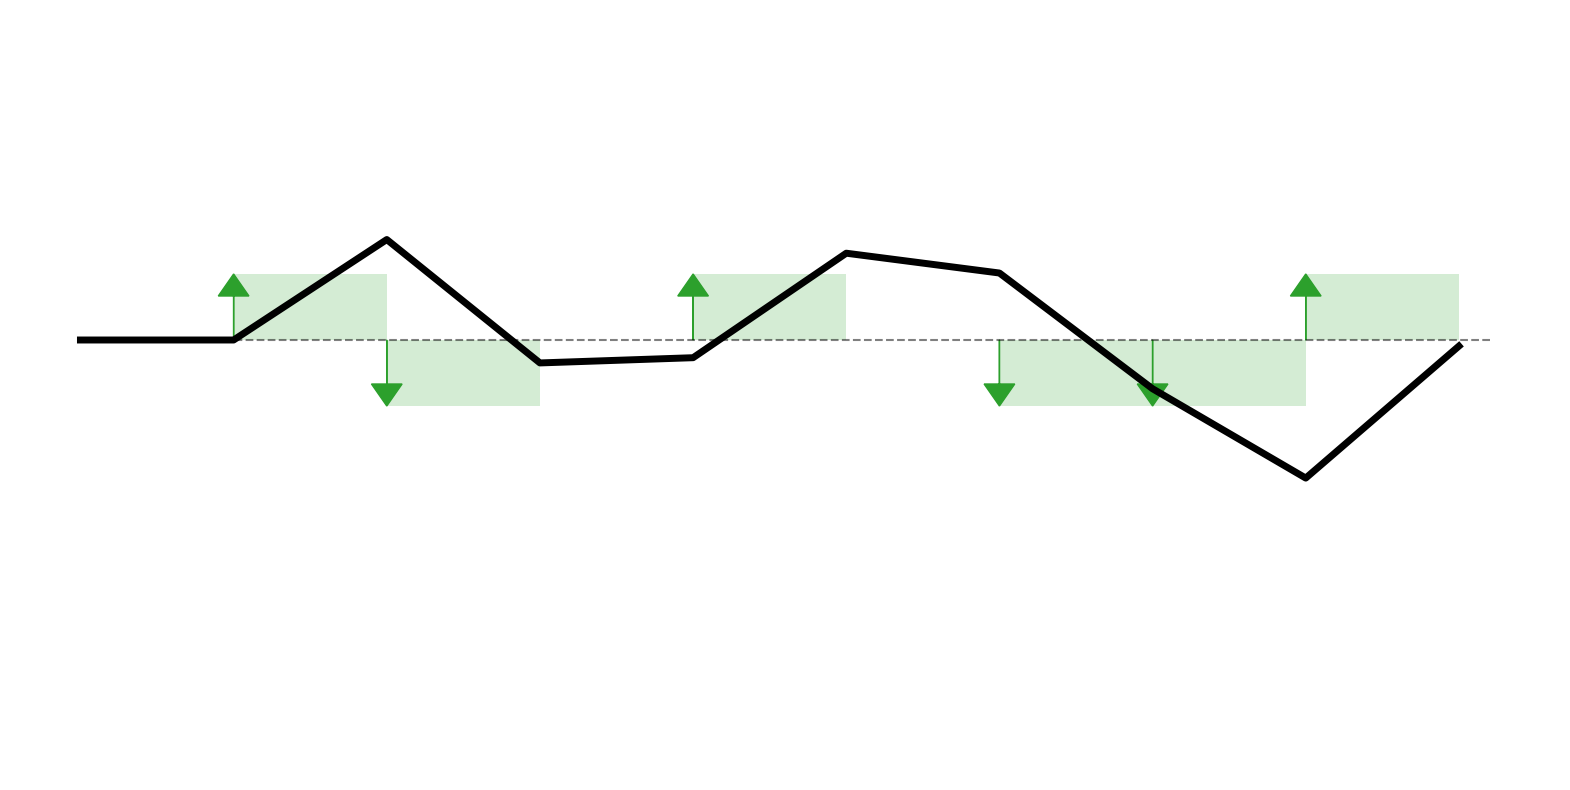

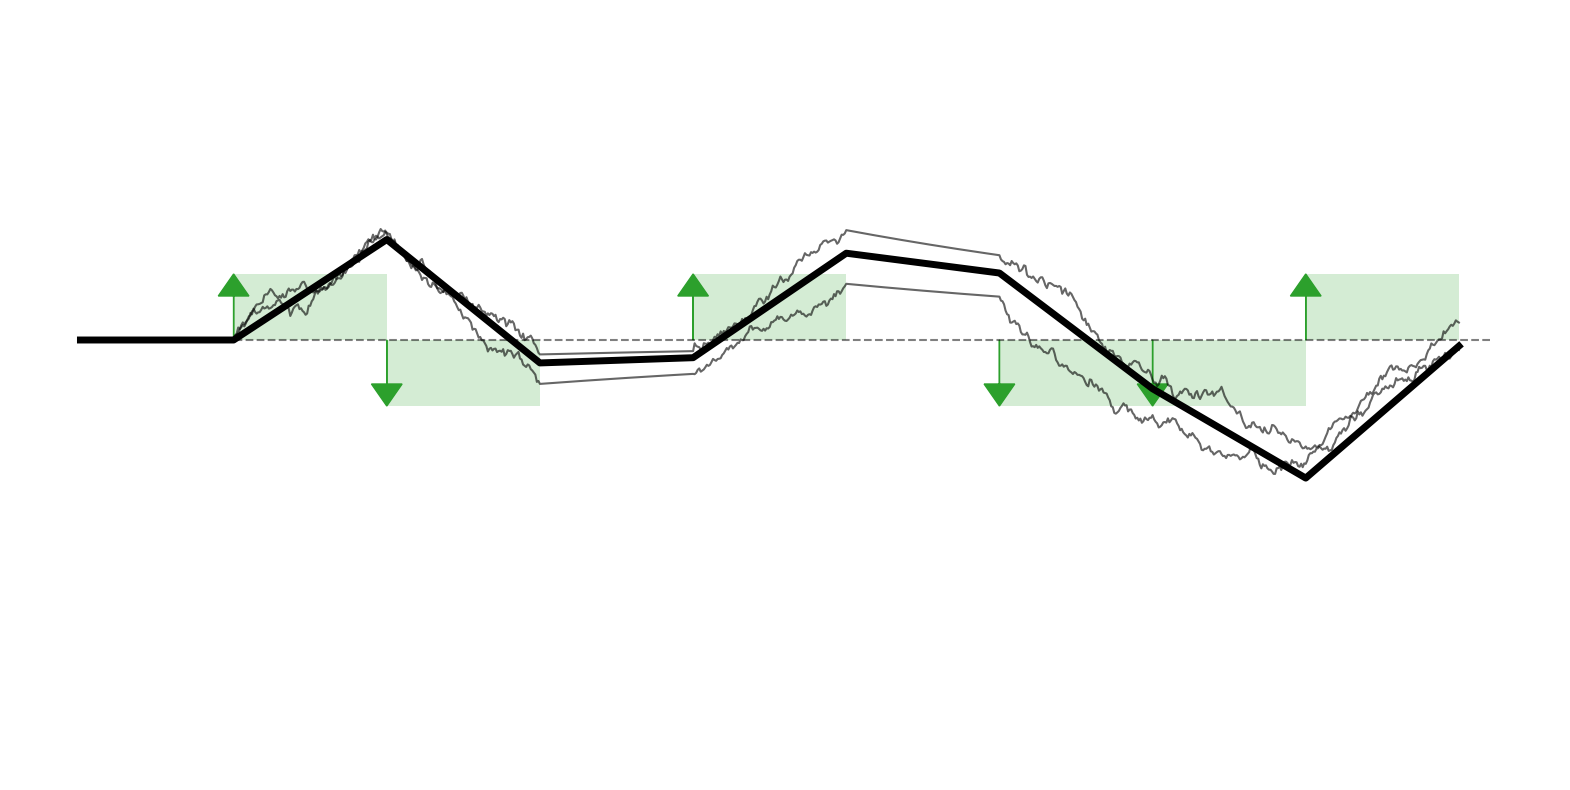

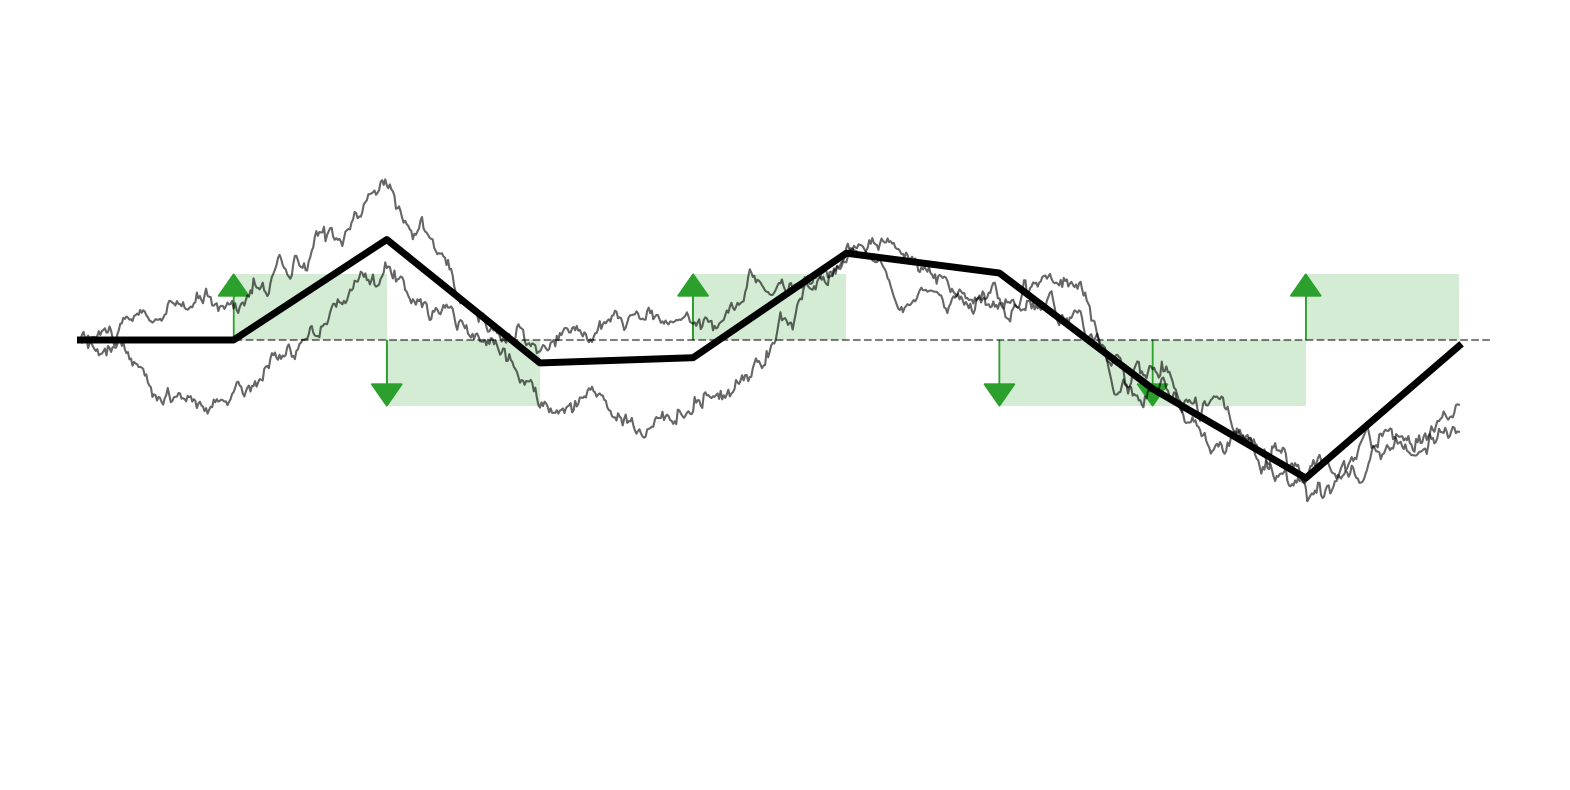

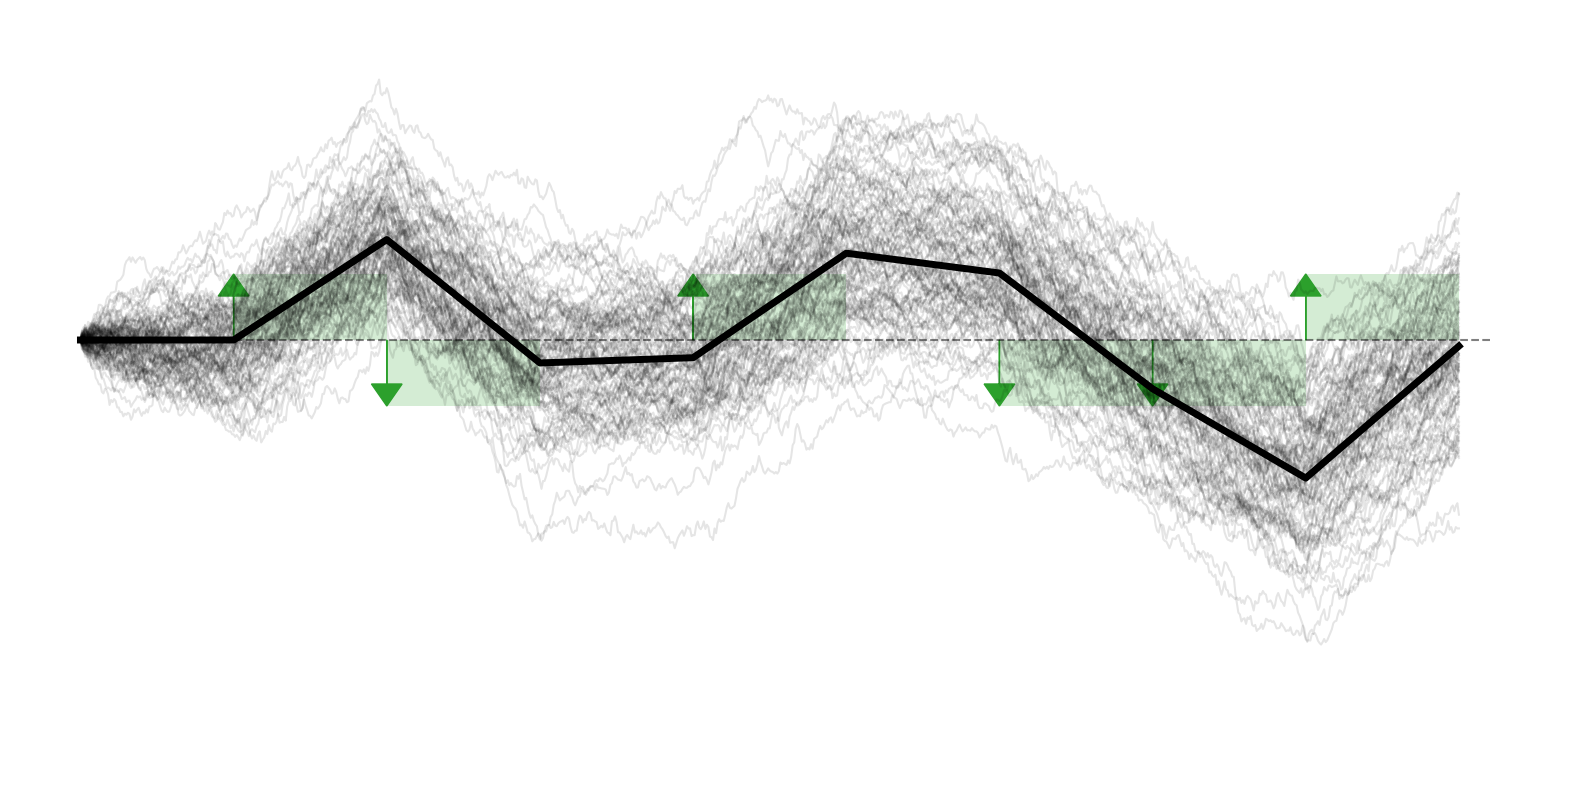

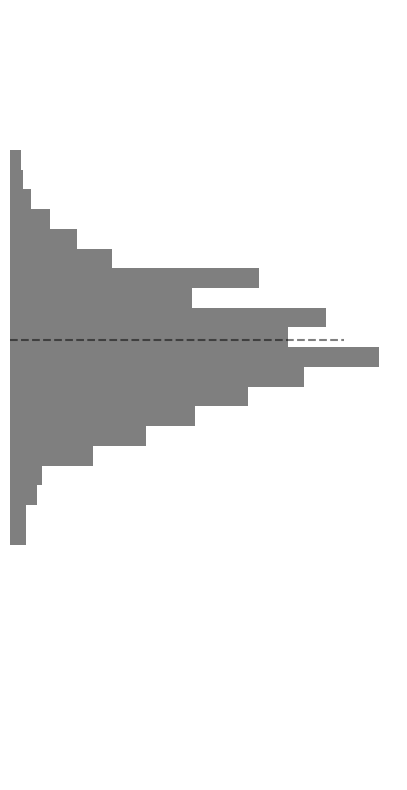

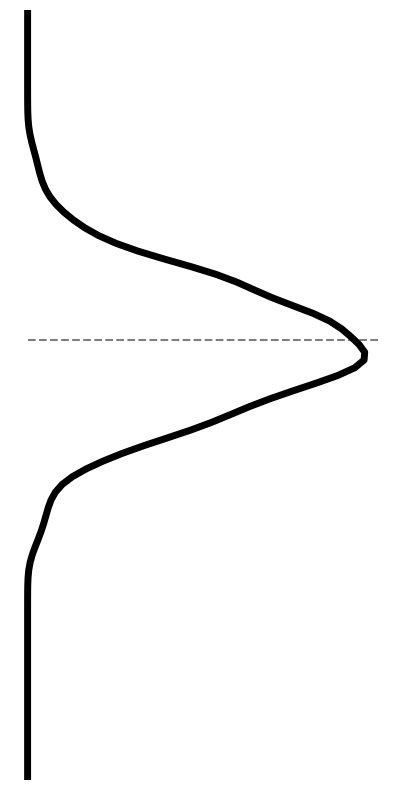

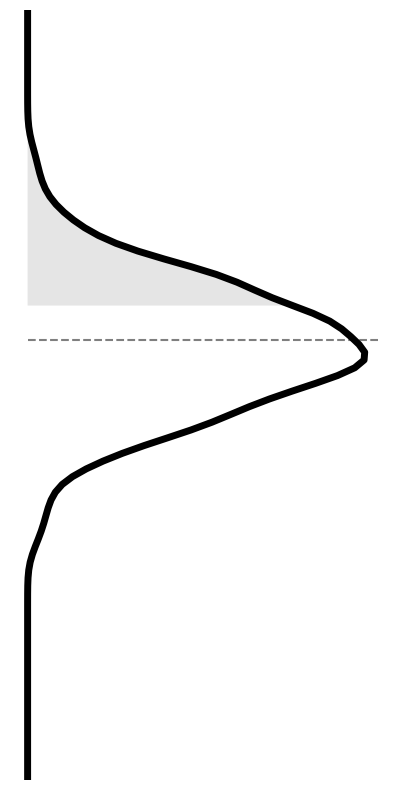

In [169]:
setup_seed(10)
B = 100000
params = [ 1, 0.0, 0.0, 0]
model_name = 'B-G-L0S-O-N-'
model = DM_model(params=params, model_name=model_name)
dt = model.dt/model.temporalDiscretization
_, _ = model.simulate(seqC.reshape(-1))
a_stc = model.aFinal#[:, ::100]

fig, ax = plt.subplots(figsize=(20, 10))
# mean trace
a_idx = np.arange(len(a)*100)[::100]
plt.plot(a_idx, a, 'k', alpha=1, lw=5)

for i in range(len(a)):
    amplitude = seqC.reshape(-1)[i]
    if amplitude != 0:
        ax.arrow(a_idx[i], 0, 0, amplitude*0.05, head_width=20, head_length=0.02, fc='tab:green', ec='tab:green')
        if amplitude >0:
            plt.fill_between([i*100, (i+1)*100], 0.8*0.075, 0, facecolor='tab:green', alpha=0.2)
        if amplitude <0:
            plt.fill_between([i*100, (i+1)*100], 0, -0.8*0.075, facecolor='tab:green', alpha=0.2)
            
# for i in range(100):
#     plt.plot(a_stc[i, :], 'k', alpha=0.1)
    
# draw a zero line
plt.plot([0, (len(a)-1)*100+20], [0, 0], 'k--', alpha=0.5)
plt.ylim([-0.4, 0.3])
ax.set_axis_off()
save_fig = f"{fig_dir}/model_0.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

setup_seed(10)
B = 100000
params = [ 1, 0.0, 0.0, B, Lambda]
model_name = 'B0G-L0S-O-N-'
model = DM_model(params=params, model_name=model_name)
dt = model.dt/model.temporalDiscretization
_, _ = model.simulate(seqC.reshape(-1))
a_stc = model.aFinal#[:, ::100]

fig, ax = plt.subplots(figsize=(20, 10))
# mean trace
a_idx = np.arange(len(a)*100)[::100]
plt.plot(a_idx, a, 'k', alpha=1, lw=5)

for i in range(len(a)):
    amplitude = seqC.reshape(-1)[i]
    if amplitude != 0:
        ax.arrow(a_idx[i], 0, 0, amplitude*0.05, head_width=20, head_length=0.02, fc='tab:green', ec='tab:green')
        if amplitude >0:
            plt.fill_between([i*100, (i+1)*100], 0.8*0.075, 0, facecolor='tab:green', alpha=0.2)
        if amplitude <0:
            plt.fill_between([i*100, (i+1)*100], 0, -0.8*0.075, facecolor='tab:green', alpha=0.2)
            
# for i in range(100):
#     plt.plot(a_stc[i, :], 'k', alpha=0.1)
    
# draw a zero line
plt.plot([0, (len(a)-1)*100+20], [0, 0], 'k--', alpha=0.5)
plt.ylim([-0.4, 0.3])
ax.set_axis_off()
save_fig = f"{fig_dir}/model_1.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

setup_seed(10)
B = 100000
params = [ 1, 0.0, 0.05, B, Lambda]
model_name = 'B0G-L0S-O-N-'
model = DM_model(params=params, model_name=model_name)
dt = model.dt/model.temporalDiscretization
_, _ = model.simulate(seqC.reshape(-1))
a_stc = model.aFinal#[:, ::100]

fig, ax = plt.subplots(figsize=(20, 10))
# mean trace
a_idx = np.arange(len(a)*100)[::100]
plt.plot(a_idx, a, 'k', alpha=1, lw=5)

for i in range(len(a)):
    amplitude = seqC.reshape(-1)[i]
    if amplitude != 0:
        ax.arrow(a_idx[i], 0, 0, amplitude*0.05, head_width=20, head_length=0.02, fc='tab:green', ec='tab:green')
        if amplitude >0:
            plt.fill_between([i*100, (i+1)*100], 0.8*0.075, 0, facecolor='tab:green', alpha=0.2)
        if amplitude <0:
            plt.fill_between([i*100, (i+1)*100], 0, -0.8*0.075, facecolor='tab:green', alpha=0.2)
            
for i in range(2):
    plt.plot(a_stc[i, :], 'k', alpha=0.6)
    
# draw a zero line
plt.plot([0, (len(a)-1)*100+20], [0, 0], 'k--', alpha=0.5)
plt.ylim([-0.4, 0.3])
ax.set_axis_off()
save_fig = f"{fig_dir}/model_2.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

setup_seed(10)
B = 100000
params = [ 1, 0.01, 0.05, B, Lambda]
model_name = 'B0G-L0S-O-N-'
model = DM_model(params=params, model_name=model_name)
dt = model.dt/model.temporalDiscretization
_, _ = model.simulate(seqC.reshape(-1))
a_stc = model.aFinal#[:, ::100]

fig, ax = plt.subplots(figsize=(20, 10))
# mean trace
a_idx = np.arange(len(a)*100)[::100]
plt.plot(a_idx, a, 'k', alpha=1, lw=5)

for i in range(len(a)):
    amplitude = seqC.reshape(-1)[i]
    if amplitude != 0:
        ax.arrow(a_idx[i], 0, 0, amplitude*0.05, head_width=20, head_length=0.02, fc='tab:green', ec='tab:green')
        if amplitude >0:
            plt.fill_between([i*100, (i+1)*100], 0.8*0.075, 0, facecolor='tab:green', alpha=0.2)
        if amplitude <0:
            plt.fill_between([i*100, (i+1)*100], 0, -0.8*0.075, facecolor='tab:green', alpha=0.2)
            
for i in range(2):
    plt.plot(a_stc[i, :], 'k', alpha=0.6)
    
# draw a zero line
plt.plot([0, (len(a)-1)*100+20], [0, 0], 'k--', alpha=0.5)
plt.ylim([-0.4, 0.3])
ax.set_axis_off()
save_fig = f"{fig_dir}/model_3.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

setup_seed(10)
B = 100000
params = [ 1, 0.01, 0.05, B, Lambda]
model_name = 'B0G-L0S-O-N-'
model = DM_model(params=params, model_name=model_name)
dt = model.dt/model.temporalDiscretization
_, _ = model.simulate(seqC.reshape(-1))
a_stc = model.aFinal#[:, ::100]

fig, ax = plt.subplots(figsize=(20, 10))
# mean trace
a_idx = np.arange(len(a)*100)[::100]
plt.plot(a_idx, a, 'k', alpha=1, lw=5)

for i in range(len(a)):
    amplitude = seqC.reshape(-1)[i]
    if amplitude != 0:
        ax.arrow(a_idx[i], 0, 0, amplitude*0.05, head_width=20, head_length=0.02, fc='tab:green', ec='tab:green')
        if amplitude >0:
            plt.fill_between([i*100, (i+1)*100], 0.8*0.075, 0, facecolor='tab:green', alpha=0.2)
        if amplitude <0:
            plt.fill_between([i*100, (i+1)*100], 0, -0.8*0.075, facecolor='tab:green', alpha=0.2)
            
for i in range(100):
    plt.plot(a_stc[i, :], 'k', alpha=0.1)
    
# draw a zero line
plt.plot([0, (len(a)-1)*100+20], [0, 0], 'k--', alpha=0.5)
plt.ylim([-0.4, 0.3])
ax.set_axis_off()

save_fig = f"{fig_dir}/model_7.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

fig, ax = plt.subplots(figsize=(5, 10))
_ = ax.hist(a_stc[:, -1], bins=20, orientation='horizontal', color='tab:gray', alpha=1)
# plot a horizontal line at 0
plt.plot([0, 125], [0, 0], 'k--', alpha=0.5)
plt.ylim([-0.4, 0.3])
ax.set_axis_off()

save_fig = f"{fig_dir}/model_4.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

# draw a kde plot
fig, ax = plt.subplots(figsize=(5, 10))
kde = gaussian_kde(a_stc[:, -1])
x = np.linspace(-0.4, 0.3, 100)
y = kde(x)
plt.plot(y, x, 'k', alpha=1, lw=5)
plt.plot([0, 7], [0, 0], 'k--', alpha=0.5)
plt.ylim([-0.4, 0.3])
ax.set_axis_off()

save_fig = f"{fig_dir}/model_5.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

fig, ax = plt.subplots(figsize=(5, 10))
kde = gaussian_kde(a_stc[:, -1])
x = np.linspace(-0.4, 0.3, 100)
y = kde(x)
plt.plot(y, x, 'k', alpha=1, lw=5)
plt.plot([0, 7], [0, 0], 'k--', alpha=0.5)
# fill a area for y>1
plt.fill_betweenx(x, y, where=x>0.03, facecolor='tab:gray', alpha=0.2)

plt.ylim([-0.4, 0.3])
ax.set_axis_off()

save_fig = f"{fig_dir}/model_6.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

MoG

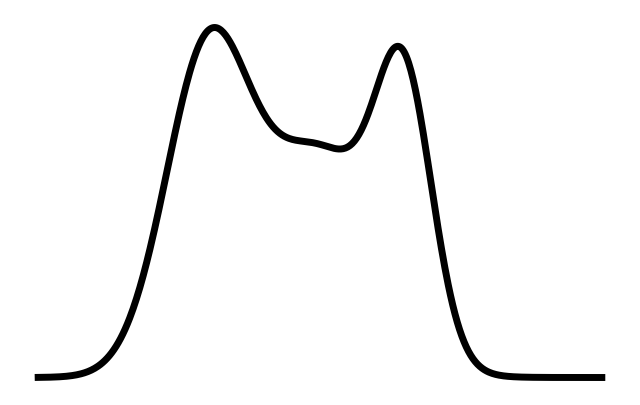

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Generate the x values
x_values = np.linspace(-10, 10, 500)


# Parameters for Gaussian 1 (A1, mu1, sigma1)
params1 = [1, -4, 1.5]
# Parameters for Gaussian 2 (A2, mu2, sigma2)
params2 = [0.7, 0, 2]
# Parameters for Gaussian 3 (A3, mu3, sigma3)
params3 = [0.8, 3, 1]


# Calculate the individual Gaussian curves
gaussian1 = gaussian(x_values, params1[0], params1[1], params1[2])
gaussian2 = gaussian(x_values, params2[0], params2[1], params2[2])
gaussian3 = gaussian(x_values, params3[0], params3[1], params3[2])

# Calculate the mixture of Gaussians
mixture = gaussian1 + gaussian2 + gaussian3

fig, ax = plt.subplots(figsize=(8, 5))
# Plot each Gaussian
# ax.plot(x_values, gaussian1, label='Gaussian 1', linestyle='--')
# ax.plot(x_values, gaussian2, label='Gaussian 2', linestyle='--')
# ax.plot(x_values, gaussian3, label='Gaussian 3', linestyle='--')

# Plot the mixture of Gaussians
ax.plot(x_values, mixture, label='Mixture', linewidth=5, color='k')

# Add labels and title
# ax.set_xlabel('x')
# ax.set_ylabel('f(x)')
# ax.set_title('Mixture of Gaussians')
# ax.legend()

ax.set_axis_off()

save_fig = f"{fig_dir}/MoG_1.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

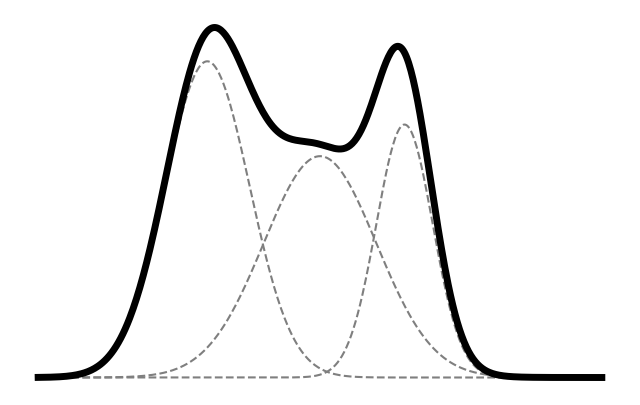

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Generate the x values
x_values = np.linspace(-10, 10, 500)


# Parameters for Gaussian 1 (A1, mu1, sigma1)
params1 = [1, -4, 1.5]
# Parameters for Gaussian 2 (A2, mu2, sigma2)
params2 = [0.7, 0, 2]
# Parameters for Gaussian 3 (A3, mu3, sigma3)
params3 = [0.8, 3, 1]


# Calculate the individual Gaussian curves
gaussian1 = gaussian(x_values, params1[0], params1[1], params1[2])
gaussian2 = gaussian(x_values, params2[0], params2[1], params2[2])
gaussian3 = gaussian(x_values, params3[0], params3[1], params3[2])

# Calculate the mixture of Gaussians
mixture = gaussian1 + gaussian2 + gaussian3

fig, ax = plt.subplots(figsize=(8, 5))
# Plot each Gaussian
ax.plot(x_values, gaussian1, label='Gaussian 1', linestyle='--', color='tab:gray')
ax.plot(x_values, gaussian2, label='Gaussian 2', linestyle='--', color='tab:gray')
ax.plot(x_values, gaussian3, label='Gaussian 3', linestyle='--', color='tab:gray')

# Plot the mixture of Gaussians
ax.plot(x_values, mixture, label='Mixture', linewidth=5, color='k')

# Add labels and title
# ax.set_xlabel('x')
# ax.set_ylabel('f(x)')
# ax.set_title('Mixture of Gaussians')
# ax.legend()

ax.set_axis_off()

save_fig = f"{fig_dir}/MoG_2.png"
plt.savefig(save_fig, dpi=300, bbox_inches="tight",pad_inches=0)

## test

==>> seqC.shape: torch.Size([14700, 15])
==>> chR.shape: torch.Size([14700, 1])


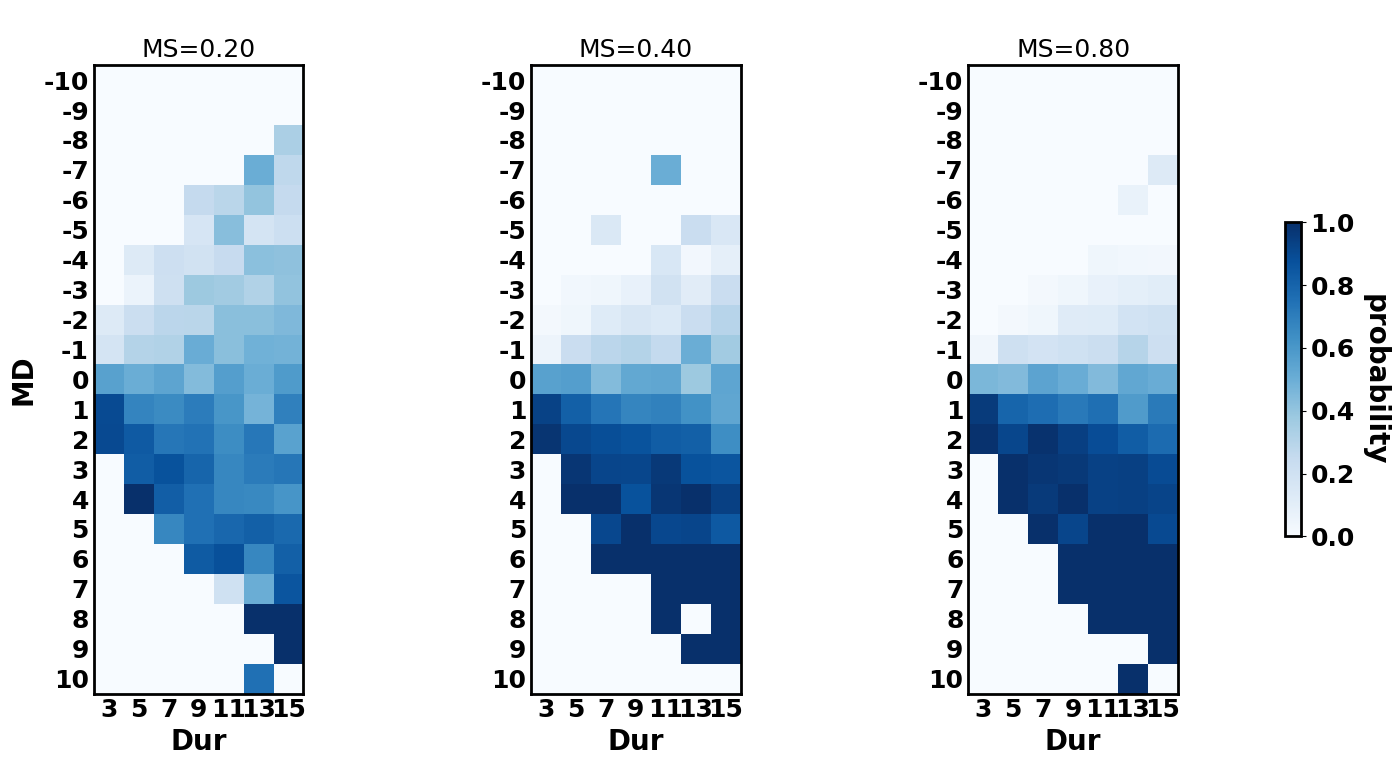

In [18]:
DATA_PATH = adapt_path("~/tmp/NSC/data/dataset/dataset-L0-Eset0-100sets-T500.h5")
idx_set = 0
idx_theta = 10

# =================================================== load h5 dataset file
f = h5py.File(DATA_PATH, "r")
"""
f has keys ['set_0', 'set_1', 'set_10', 'set_11']
in one set, there are 3 keys: ['seqC', 'theta', 'probR']
seqC:  [D, M, S, 15]            - [7, 3, 700, 15]
theta: [T, 4]                   - [5000, 4]
probR: [D, M, S, T, 1]          - [7, 3, 700, 5000, 1]
"""
seqC = torch.from_numpy(f[f"set_{idx_set}"]["seqC"][:]).type(torch.float32)
theta = torch.from_numpy(f[f"set_{idx_set}"]["theta"][idx_theta, :]).type(torch.float32)
probR = torch.from_numpy(f[f"set_{idx_set}"]["probR"][:, :, :, idx_theta, :]).type(torch.float32)
f.close()

D, M, S = seqC.shape[0], seqC.shape[1], seqC.shape[2]
DMS = D * M * S

sID = 2
trials = sio.loadmat(adapt_path("~/tmp/NSC/data/trials.mat"))
trials_data = trials["data"]
trials_info = trials["info"]
subjectID = torch.from_numpy(trials_data[0, -1])
idx_subj = (subjectID == sID).squeeze(-1)
chR = torch.from_numpy(trials_data[0, 42][idx_subj]).type(torch.float32)
seqC = torch.from_numpy(trials_data[0, 0][idx_subj]).type(torch.float32)
print(f"==>> seqC.shape: {seqC.shape}")
print(f"==>> chR.shape: {chR.shape}")

FG = Feature_Generator()
FG.compute_kernels(seqC, chR, D, M, S)

save_fig = fig_dir  / 'npe-f-F1-kernel.png'
FG.plot_kernels(kernel=1, no_dist=True, save_fig=save_fig)

==>> seqC.shape: torch.Size([14700, 15])
==>> chR.shape: torch.Size([14700, 1])


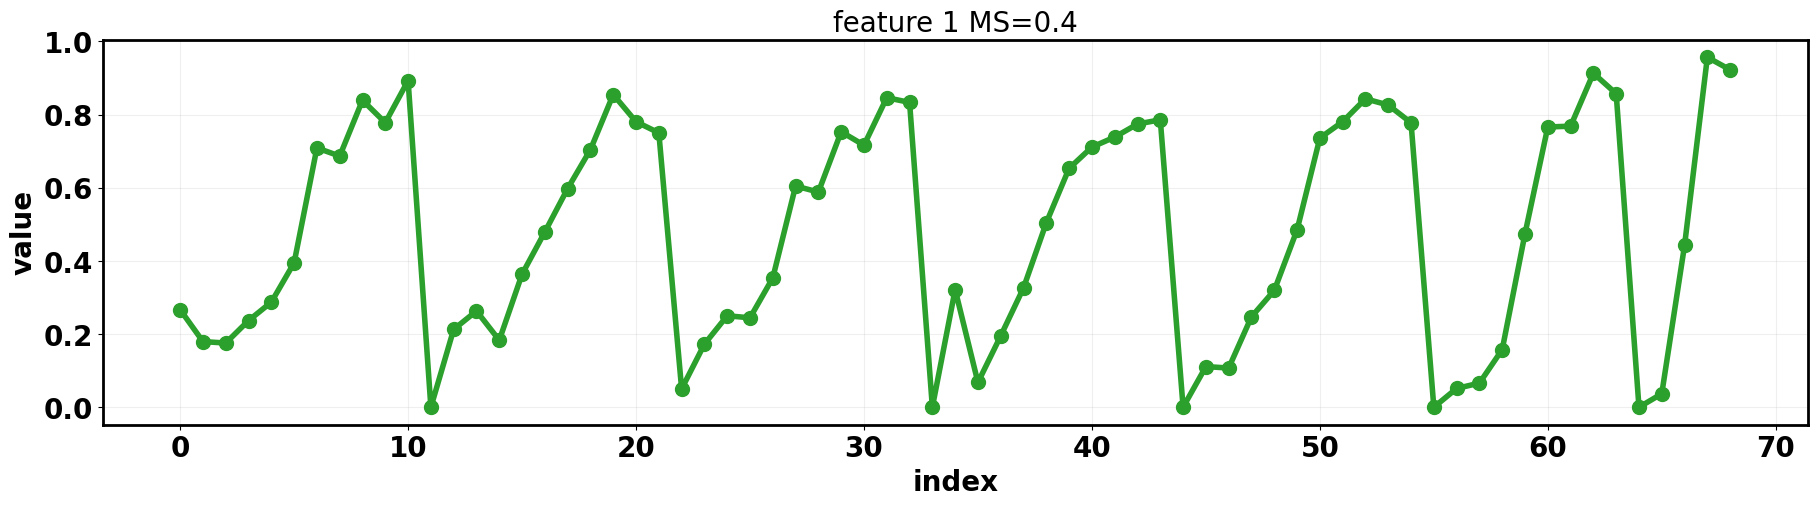

In [32]:
sID = 5
trials = sio.loadmat(adapt_path("~/tmp/NSC/data/trials.mat"))
trials_data = trials["data"]
trials_info = trials["info"]
subjectID = torch.from_numpy(trials_data[0, -1])
idx_subj = (subjectID == sID).squeeze(-1)
chR = torch.from_numpy(trials_data[0, 42][idx_subj]).type(torch.float32)
seqC = torch.from_numpy(trials_data[0, 0][idx_subj]).type(torch.float32)
print(f"==>> seqC.shape: {seqC.shape}")
print(f"==>> chR.shape: {chR.shape}")

FG = Feature_Generator()
FG.compute_kernels(seqC, chR, D, M, S)

feature_1s, feature_2s, feature_3s, feature_4s, feature_5s = FG.get_features()
feature_5s_normed = convert_array_range(feature_5s, [-1, 1], [0, 1])
features_ = [feature_1s, feature_2s, feature_3s, feature_4s, feature_5s_normed]

feature_ = []
for i in range(M):
    for j in range(len(features_)):
        feature_.append(features_[j][i])
feature_ = torch.cat(feature_)

fig, ax= plt.subplots(figsize=(22, 5))

# ax = axes[0]
# for i in range(M):
#     plt.plot(feature_1s[i], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=2, color=colors[i])
plt.plot(feature_1s[1], ".-", label=f"MS={FG.MS_list[i]:.1f}", linewidth=4, color=colors[i], markersize=20)
plt.title("feature 1 MS=0.4")
plt.xlabel("index")
plt.ylabel("value")
plt.grid(alpha=0.2)

save_fig = fig_dir / 'npe-f-F1.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [34]:
# %% ========== load training data
pipeline_version = "p4a"
train_id = "train_L0_p4a"
exp_id = "p4a-F1345-cnn-maf3"
# exp_id = "p4a-F1345-cnn-maf3-B2"
log_exp_id = "npe-f-F1345-maf3"
# log_exp_id = "npe-f-F1345-maf3-B2"

log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id

# %% ========== load the config.yaml file
config_file = log_dir / "config.yaml"
config = adapt_path(config_file)

with open(config, "r") as f:
    config = yaml.safe_load(f)

prior_min = config["prior"]["prior_min"]
prior_max = config["prior"]["prior_max"]
# prior_labels = config["prior"]["prior_labels"]
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]
num_params = len(prior_labels)


# %% ==========  get posterior samples
config, model_path = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver, posterior, train_loader, valid_loader, train_dataset, valid_dataset = get_posterior(
    model_path=model_path,
    config=config,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=True,
)

==>> config_path: /home/wehe/data/NSC/codes/src/train/logs/train_L0_p4a/p4a-F1345-cnn-maf3/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---



/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
cnn

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets len_feature_each_type=[69, 15, 12, 56]
loading 18sets T100.00%=500 C25...


100%|██████████| 18/18 [00:00<00:00, 43.61it/s]


dataset info: ==> self.total_samples=225000 => self.x.shape=torch.Size([18, 500, 25, 456, 1]) self.theta.shape=torch.Size([18, 500, 4])

[validation] sets len_feature_each_type=[69, 15, 12, 56]
loading 2sets T100.00%=500 C25...


100%|██████████| 2/2 [00:00<00:00, 48.65it/s]

dataset info: ==> self.total_samples=25000 => self.x.shape=torch.Size([2, 500, 25, 456, 1]) self.theta.shape=torch.Size([2, 500, 4])
loader_kwargs={'batch_size': 20, 'drop_last': False, 'shuffle': True, 'pin_memory': False, 'num_workers': 4, 'worker_init_fn': <function seed_worker at 0x7fbcbb669fc0>, 'prefetch_factor': 2}

collect posterior sets... 

takes 0.56 seconds = 0.01 minutes

finished build network
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=8, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=128, bias=True)
          (context_layer): Linear(in_features=256, out_features=128, bias=True)

In [36]:
normed_limits = solver._get_limits()
designed_limits = get_limits(config.prior.prior_min, config.prior.prior_max)

test dataset

In [39]:
# prepare varying theta values
print(f"{designed_limits=}")
ref_theta_values = [1, 10, 10, 1]

step = 7
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values

print(f"==>> theta_values: {theta_values}")    


# prepare the seqC_o from unseen dataset ['set_25']
f = h5py.File(DATA_PATH, "r")
f.keys()
seqC = f['set_25']['seqC'][:]
f.close()
print(f"==>> seqC.shape: {seqC.shape}")
print(f'{seqC[0,0,:5,:]=}')
D, M, S = seqC.shape[0], seqC.shape[1], seqC.shape[2]
DMS = D * M * S

# run the simulator
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC,
    prior=theta_values,
    num_workers=16,
    privided_prior=True,
)


# === bernoulli sampling using pytorch
chRs = torch.from_numpy(probR).repeat_interleave(10, dim=-1)
chRs = torch.bernoulli(chRs)
print(f"==>> chR.shape: {chRs.shape}")


# === extract feature from seqC+chR
chosen_features_lens = config.dataset.feature_lengths
n_features = sum(chosen_features_lens)
print(f"==>> n_features: {n_features*M}")

T_idx = 0
C_idx = 0
nT = theta_values.shape[0]
Fs = torch.zeros((nT, n_features * M))

for T_idx in tqdm(range(nT)):
    chR = chRs[:, :, :, T_idx, C_idx].unsqueeze(-1)
    F = feature_extraction(seqC, chR, config)
    Fs[T_idx] = F

print(f"==>> Fs.shape: {Fs.shape}")

designed_limits=[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
==>> theta_values: [[ -2.5         10.          10.           1.        ]
 [ -1.66666667  10.          10.           1.        ]
 [ -0.83333333  10.          10.           1.        ]
 [  0.          10.          10.           1.        ]
 [  0.83333333  10.          10.           1.        ]
 [  1.66666667  10.          10.           1.        ]
 [  2.5         10.          10.           1.        ]
 [  1.           0.          10.           1.        ]
 [  1.          12.83333333  10.           1.        ]
 [  1.          25.66666667  10.           1.        ]
 [  1.          38.5         10.           1.        ]
 [  1.          51.33333333  10.           1.        ]
 [  1.          64.16666667  10.           1.        ]
 [  1.          77.          10.           1.        ]
 [  1.          10.           0.           1.        ]
 [  1.          10.           3.           1.        ]
 [  1.          10.           6.          

/tmp/ipykernel_2877740/1431039874.py:28: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 478 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 22800 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done 98320 tasks      | elapsed:    9.6s
[Parallel(n_jobs=16)]: Done 213520 tasks      | elapsed:   20.3s
[Parallel(n_jobs=16)]: Done 354320 tasks      | elapsed:   39.2s
/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=16)]: Done 411600 out of 4

time elapsed for simulation: 0.82 minutes
stacking the results
done stacking the results

seqC.shape: (7, 3, 700, 15), params.shape: (28, 4), probR.shape: (7, 3, 700, 28, 1)
==>> chR.shape: torch.Size([7, 3, 700, 28, 10])
==>> n_features: 456


100%|██████████| 28/28 [00:17<00:00,  1.57it/s]

==>> Fs.shape: torch.Size([28, 456])


In [40]:
all_samples = np.zeros((4, step - 2, 20_000, 4))
all_thetas = np.zeros((4, step - 2, 4))

for T in range(nT):
    if T % step == 0 or T % step == step - 1:
        continue

    moving_theta_idx = T // step
    trial_idx = T % step - 1

    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    
    F_test = Fs[T, :].unsqueeze(0).unsqueeze(-1).cuda()

    samples = sampling_from_posterior(
        "cuda",
        posterior,
        F_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

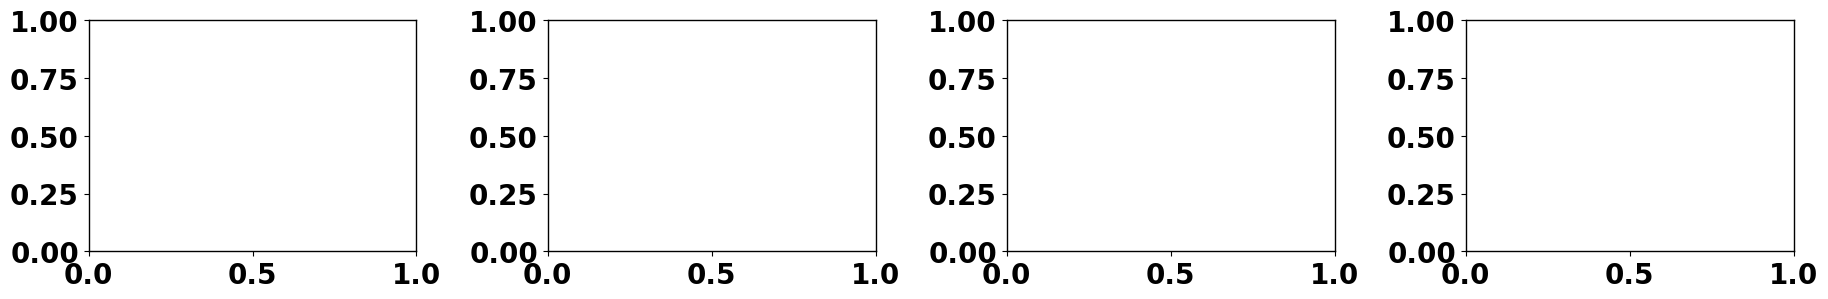

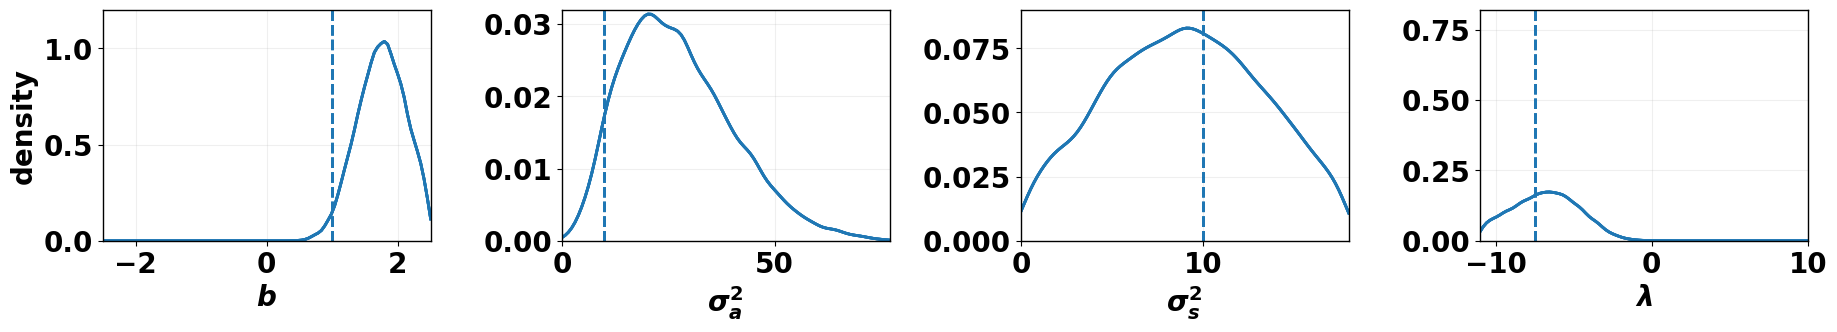

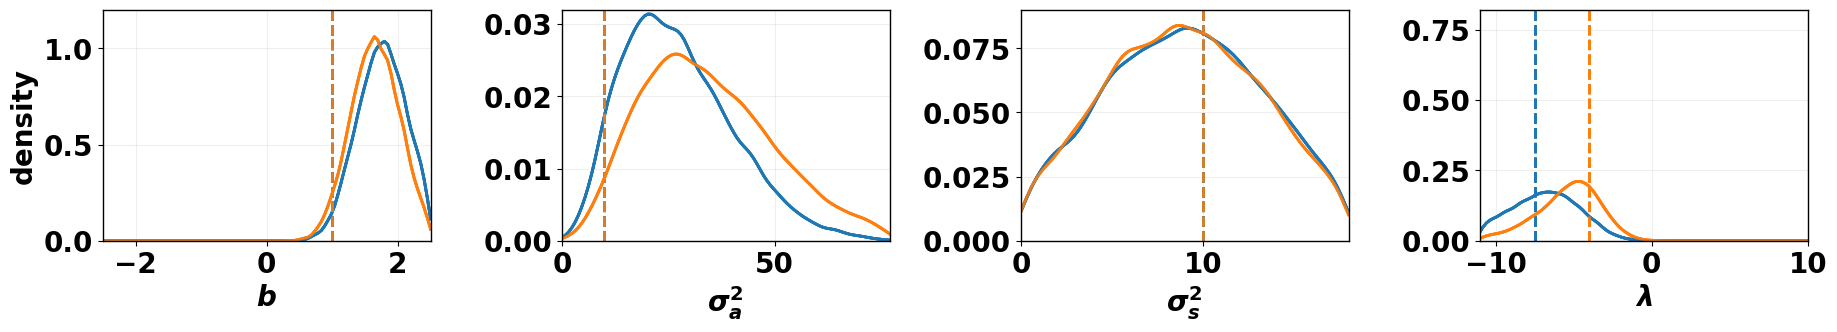

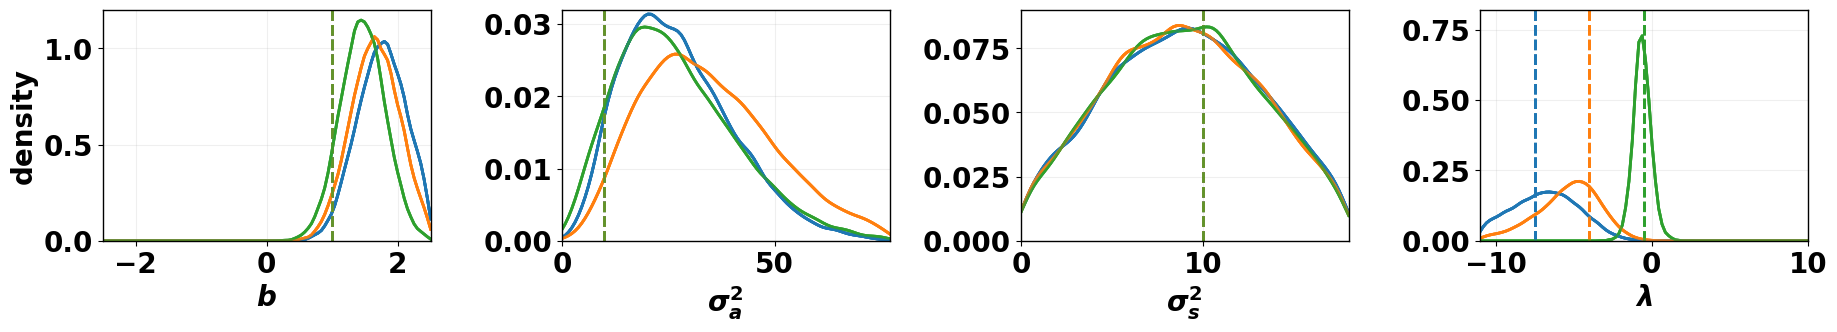

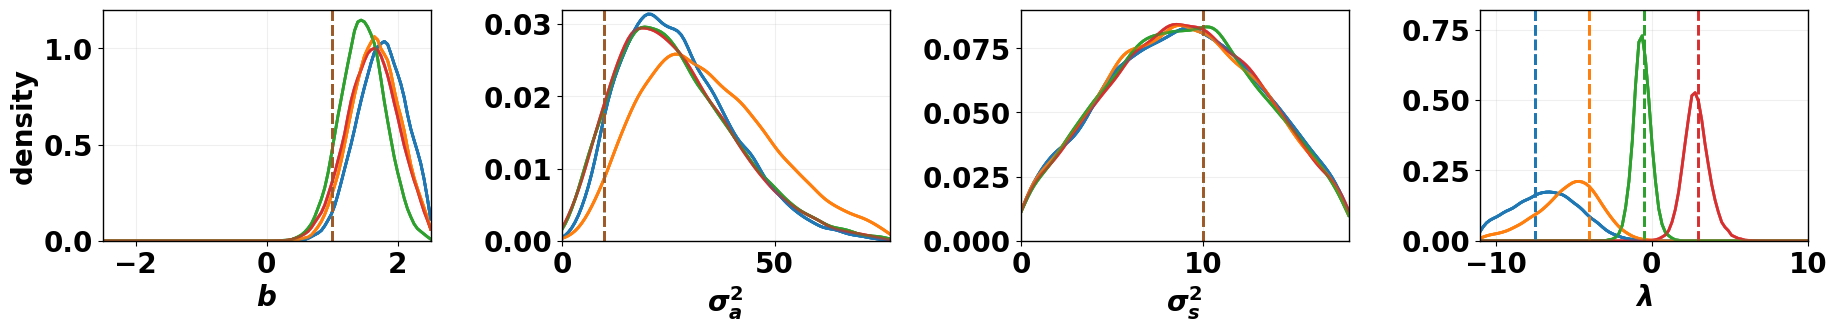

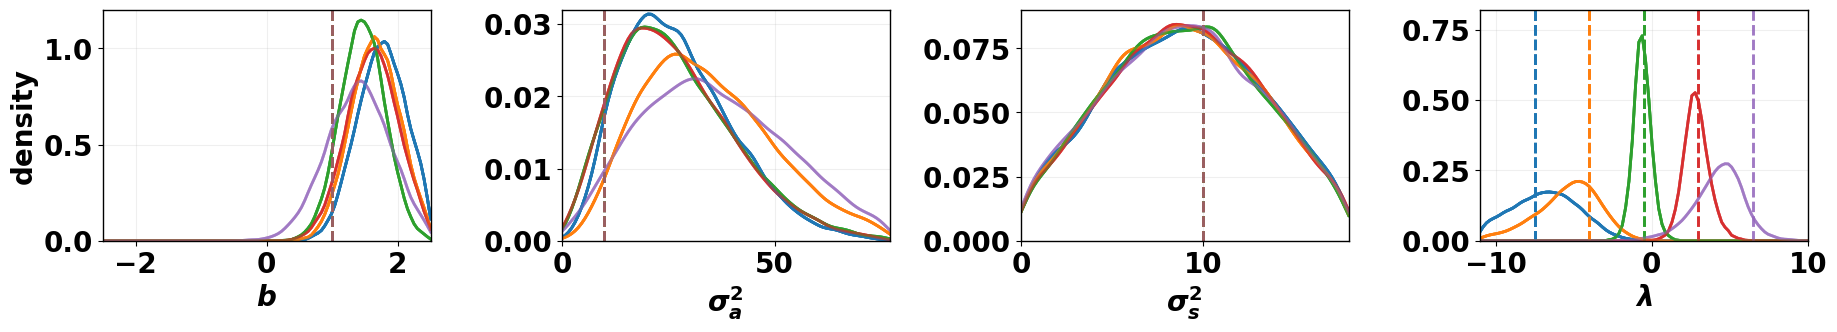

In [89]:
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]

fig.subplots_adjust(wspace=0.4)
num_trials = all_thetas_dr.shape[1]

dest_limits = designed_limits

ax_ylim = [[0, 1.2], [0, 0.032], [0, 0.09], [0, 0.82]]
for m in range(5+1):
    fig, axes = plt.subplots(
        1, all_thetas_dr.shape[-1],
        figsize=(22, 3),
    )
    
    fig.subplots_adjust(wspace=0.4)
    for i in range(all_thetas_dr.shape[0]):
        moving_theta_idx = 0
        i=3
        samples_row = all_samples_dr[i]
        
        for k in range(m):
            for j in range(num_params):
                ax = axes[j]
                # density estimation
                density = gaussian_kde(samples_row[k, :, j], bw_method="scott")
                xs = np.linspace(dest_limits[j][0], dest_limits[j][1], 100)
                ys = density(xs)
                # plot kde
                ax.plot(
                    xs,
                    ys,
                    color=colors[k],
                    linewidth=2,
                    label=f"{prior_labels[i]}:{all_thetas_dr[i, k, i]:.2f}",
                    alpha=1 - 0.6 * k / (num_trials - 1),
                    # color=colors[j],
                )
                ax.set_xlim(dest_limits[j][0], dest_limits[j][1])
                # ax.legend(fontsize=10)
                # 
                ax.axvline(
                    all_thetas_dr[i, k, j],
                    color=colors[k],
                    linestyle="--",
                    linewidth=2,
                    alpha=1 - 0.6 * k / (num_trials - 1),
                )
                ax.grid(alpha=0.2)
                # if i == num_params-1:
                ax.set_xlabel(prior_labels[j])
                if j == 0:
                    ax.set_ylabel("density")
                
                ax.set_ylim(ax_ylim[j])
            

        save_fig = fig_dir / f'{log_exp_id}-CoV-L{m}.png'
        fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

check acc

In [47]:
from utils.inference import estimate_theta_from_post_samples
from simulator.seqC_generator import seqC_generator
from simulator.DM_model import DM_model
model_name = 'B-G-L0S-O-N-'

In [48]:
theta_estimate = np.zeros((all_samples_dr.shape[0], all_samples_dr.shape[1], all_samples_dr.shape[-1]))
for i in range(all_samples_dr.shape[0]):
    for j in tqdm(range(all_samples_dr.shape[1])):
        theta_estimate[i, j, :] = estimate_theta_from_post_samples(dest_limits, all_samples_dr[i,j], mode="mode")

100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


In [49]:
setup_seed(0)
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)
print(f"\n==>> seqC: {seqC}")


--- generated seqC info ---
dur_list: [9]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)

==>> seqC: [[[[0.  0.  0.4 0.  0.  0.  0.  0.  0.4 nan nan nan nan nan nan]]]]


In [50]:
probR_estimate = []
probR_true = []
for i in range(all_thetas_dr.shape[0]):
    for j in tqdm(range(all_thetas_dr.shape[1])):
        params=theta_estimate[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_estimate.append(probR)
        
        params=all_thetas_dr[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_true.append(probR)
        print(f"==>> true a[-1]: {a[-1]}, params: {params}, probR: {probR}")

100%|██████████| 5/5 [00:00<00:00, 167.71it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([-1.6667, 10.0000, 10.0000,  1.0000]), probR: 0.6082143658517221
==>> true a[-1]: 0.17521343308796897, params: tensor([-0.8333, 10.0000, 10.0000,  1.0000]), probR: 0.5597747953122932
==>> true a[-1]: 0.17521343308796897, params: tensor([ 0.0000, 10.0000, 10.0000,  1.0000]), probR: 0.5104225712691928
==>> true a[-1]: 0.17521343308796897, params: tensor([ 0.8333, 10.0000, 10.0000,  1.0000]), probR: 0.46091006195225603
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.6667, 10.0000, 10.0000,  1.0000]), probR: 0.4119969443373398


100%|██████████| 5/5 [00:00<00:00, 205.56it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 12.8333, 10.0000,  1.0000]), probR: 0.45675242308298025
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 25.6667, 10.0000,  1.0000]), probR: 0.46936613099889657
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 38.5000, 10.0000,  1.0000]), probR: 0.4749730239220712
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 51.3333, 10.0000,  1.0000]), probR: 0.47831970507841737
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 64.1667, 10.0000,  1.0000]), probR: 0.48060517287059257


100%|██████████| 5/5 [00:00<00:00, 533.41it/s]


==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  3.0000,  1.0000]), probR: 0.4509890664831526
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  6.0000,  1.0000]), probR: 0.4510175379474972
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000,  9.0000,  1.0000]), probR: 0.4510459598509421
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000, 12.0000,  1.0000]), probR: 0.45107433233710525
==>> true a[-1]: 0.17521343308796897, params: tensor([ 1.0000, 10.0000, 15.0000,  1.0000]), probR: 0.45110265554902296


100%|██████████| 5/5 [00:00<00:00, 331.20it/s]

==>> true a[-1]: 0.033318518296069556, params: tensor([ 1.0000, 10.0000, 10.0000, -7.5000]), probR: 0.1208575901141683
==>> true a[-1]: 0.042286641732369325, params: tensor([ 1., 10., 10., -4.]), probR: 0.19771349996394916
==>> true a[-1]: 0.0841453581602924, params: tensor([ 1.0000, 10.0000, 10.0000, -0.5000]), probR: 0.36413271512381684
==>> true a[-1]: 0.7083681807922266, params: tensor([ 1., 10., 10.,  3.]), probR: 0.4969495370996644
==>> true a[-1]: 12.36849019663851, params: tensor([ 1.0000, 10.0000, 10.0000,  6.5000]), probR: 0.5039026285791276


In [51]:
probR_estimate, probR_true = np.array(probR_estimate), np.array(probR_true)
np.abs(probR_estimate - probR_true).mean()  

0.010759427565033758

In [53]:
# compute error for each parameter
probR_estimate_parts = probR_estimate.reshape(-1, 5)
probR_true_parts = probR_true.reshape(-1, 5)
error_parts = np.abs(probR_estimate_parts - probR_true_parts).mean(axis=1)
error_parts

array([0.00780095, 0.00623532, 0.00939263, 0.01960881])

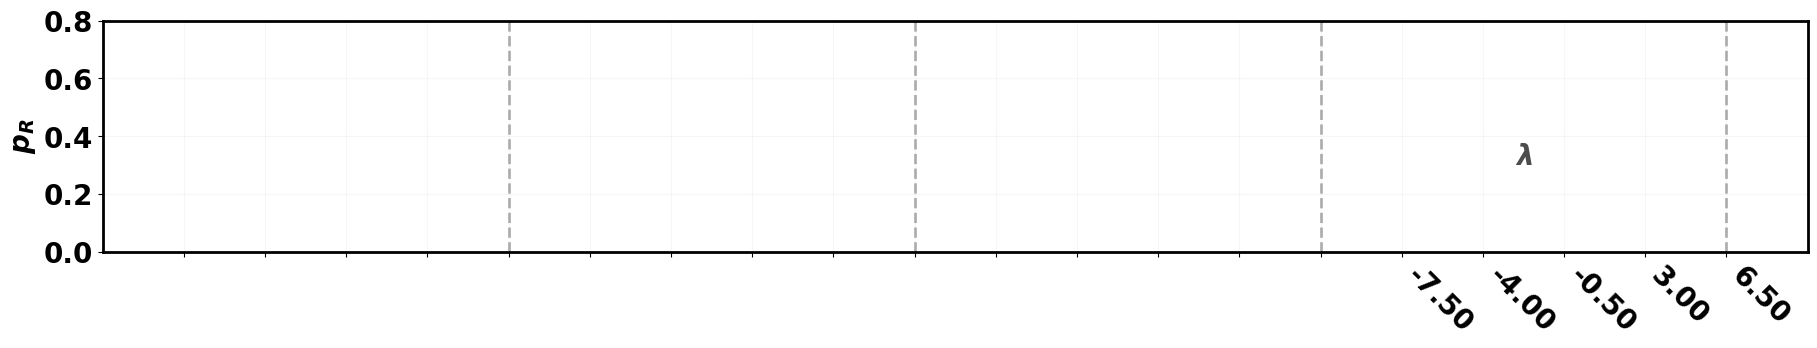

In [176]:
# font size
# plt.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(22, 3))
plt.grid(alpha=0.1) 
plt.ylabel(f'$p_R$')
# plt.xlabel('parameter value [true]')
plt.ylim([0,.8])
plt.xlim([-1, 20])
# plt vlines
plt.vlines(np.arange(4,20,5), 0, 1, colors='k', linestyles='--', lw=2, alpha=0.3)
# text align in center
# plt.text(1.5, 0.3, f'$b$\n$\epsilon$ {error_parts[0]:.3f}', fontsize=12, ha='center', alpha=0.3)
# plt.text(6.5, 0.3, f'$\sigma^2_a$\n$\epsilon$ {error_parts[1]:.3f}', fontsize=12, ha='center', alpha=0.3)
# plt.text(11.5, 0.3, f'$\sigma^2_s$\n$\epsilon$ {error_parts[2]:.3f}', fontsize=12, ha='center', alpha=0.3)
# plt.text(16.5, 0.3, f'$\lambda$\n$\epsilon$ {error_parts[3]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(16.5, 0.3, f'$\lambda$', fontsize=20, ha='center', alpha=0.7)


idx = 15
plt.plot(np.arange(15,idx), probR_estimate[np.arange(15,idx)], 'v', label='Estimate', lw=2, markersize=10, alpha=0.6, color=colors[0])
plt.plot(np.arange(15,idx), probR_true[np.arange(15,idx)], 'o', label='True', lw=2, markersize=10, alpha=0.6, color=colors[1])

# tick of x axis set as 0->20
xticks_label_array=np.array([all_thetas_dr[i, :, i].numpy() for i in range(4)]).reshape(-1)
# show 2 digits xtick label
xticks_label = []
for i, x in enumerate(xticks_label_array):
    if i >= 15:
        xticks_label.append(f'{x:4.2f}')
    else:
        xticks_label.append(f' ')
plt.xticks(np.arange(20), xticks_label, rotation=-45, ha='left')


# bbox to put the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

save_fig = fig_dir / f'{log_exp_id}-test-acc-L{idx-15}.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

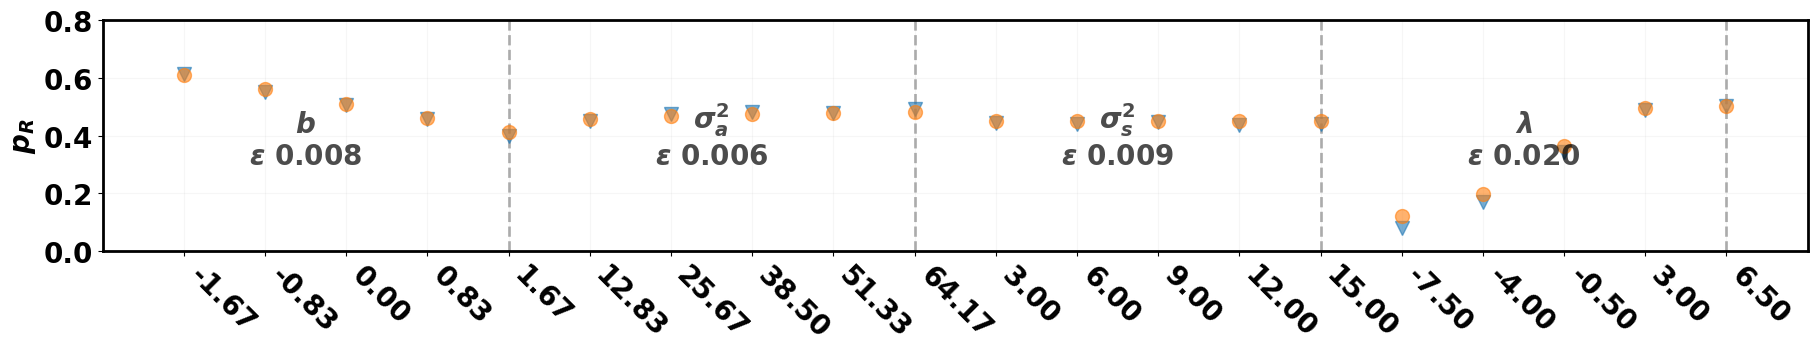

In [171]:
# font size
# plt.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(22, 3))
plt.grid(alpha=0.1) 
plt.ylabel(f'$p_R$')
# plt.xlabel('parameter value [true]')
plt.ylim([0,.8])
plt.xlim([-1, 20])
# plt vlines
plt.vlines(np.arange(4,20,5), 0, 1, colors='k', linestyles='--', lw=2, alpha=0.3)
# text align in center
plt.text(1.5, 0.3, f'$b$\n$\epsilon$ {error_parts[0]:.3f}', fontsize=20, ha='center', alpha=0.7)
plt.text(6.5, 0.3, f'$\sigma^2_a$\n$\epsilon$ {error_parts[1]:.3f}', fontsize=20, ha='center', alpha=0.7)
plt.text(11.5, 0.3, f'$\sigma^2_s$\n$\epsilon$ {error_parts[2]:.3f}', fontsize=20, ha='center', alpha=0.7)
plt.text(16.5, 0.3, f'$\lambda$\n$\epsilon$ {error_parts[3]:.3f}', fontsize=20, ha='center', alpha=0.7)
# plt.text(16.5, 0.3, f'$\lambda$', fontsize=20, ha='center', alpha=0.7)


plt.plot(probR_estimate, 'v', label='Estimate', lw=2, markersize=10, alpha=0.6, color=colors[0])
plt.plot(probR_true, 'o', label='True', lw=2, markersize=10, alpha=0.6, color=colors[1])

# tick of x axis set as 0->20
xticks_label_array=np.array([all_thetas_dr[i, :, i].numpy() for i in range(4)]).reshape(-1)
# show 2 digits xtick label
xticks_label = []
for i, x in enumerate(xticks_label_array):
    # if i >= 15:
    xticks_label.append(f'{x:4.2f}')
    # else:
        # xticks_label.append(f' ')
plt.xticks(np.arange(20), xticks_label, rotation=-45, ha='left')


# bbox to put the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

save_fig = fig_dir / f'{log_exp_id}-test-acc.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## Inference

{'exp': ['train_L0_p4a', 'p4a-F1345-cnn-maf3'],
 'range_': [[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]],
 'labels': ['bias', 'sigma2a', 'sigma2s', 'L0'],
 2: array([-0.37715086,  0.06162465,  8.49219688,  9.62184874]),
 3: array([-0.27911164,  0.09243697,  8.3697479 ,  8.77310924]),
 4: array([-0.39515806,  0.06162465,  8.70828331,  8.83193277]),
 5: array([-0.36514606,  0.03081232,  9.27731092,  9.62184874]),
 6: array([-0.25310124,  0.06162465,  9.19087635,  9.80672269]),
 7: array([-0.32513005,  0.09243697,  8.52821128,  9.71428571]),
 8: array([-0.37515006,  0.06162465,  8.78751501,  9.43697479]),
 9: array([0.34913966, 0.03081232, 8.41296519, 2.44537815]),
 10: array([0.42116847, 0.06162465, 8.4057623 , 3.98319328]),
 11: array([0.39915966, 0.09243697, 8.39135654, 3.87394958]),
 12: array([-0.05302121,  0.1232493 ,  8.56422569,  7.62184874])}

In [131]:
# fitted data
exp_name = "fitted"
exps = [exp_name]

subj_IDs = np.arange(2, 13)
from utils.subject import get_fitted_param_L0
normed_limits = [[0,1], [0,1], [0,1], [0,1]]
designed_limits = [[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
dest_limits = designed_limits

# get fitted parameters
param_path = "~/data/NSC/data/params/263 models fitPars/"
param_path = adapt_path(param_path)
bias_fitted, sigma2a_fitted, sigma2s_fitted, L0_fitted = [], [], [], []
for subj_ID in subj_IDs:
    params_fitted = get_fitted_param_L0(param_path, subj_ID)
    bias_fitted.append(params_fitted[0])
    sigma2a_fitted.append(params_fitted[1])
    sigma2s_fitted.append(params_fitted[2])
    L0_fitted.append(params_fitted[3])
bias_fitted = np.array(bias_fitted)
sigma2a_fitted = np.array(sigma2a_fitted)
sigma2s_fitted = np.array(sigma2s_fitted)
L0_fitted = np.array(L0_fitted)

bias_s = [list(bias_fitted)]
sigma2a_s = [list(sigma2a_fitted)]
sigma2s_s = [list(sigma2s_fitted)]
L0_s = [list(L0_fitted)]

subj_fitted = np.array([ [bias_fitted[i], sigma2a_fitted[i], sigma2s_fitted[i], L0_fitted[i]] for i in range(len(bias_fitted))])

# === NPE
import pickle
prior_labels = ['$b$', '$\sigma^2_a$', '$\sigma^2_s$', '$\lambda$']

exp_name = "NPE"
exps.append(exp_name)

exp_id = "train_L0_p5a/p5a-conv_lstm-corr_conv"
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / exp_id
inference_dir = log_dir / "inference"
# load pkl file
with open(inference_dir / "subj_thetas.pkl", "rb") as f:
    inference_subj = pickle.load(f)

# load parameters
bias_s.append([inference_subj[subj_ID][0] for subj_ID in subj_IDs])
sigma2a_s.append([inference_subj[subj_ID][1] for subj_ID in subj_IDs])
sigma2s_s.append([inference_subj[subj_ID][2] for subj_ID in subj_IDs])
L0_s.append([inference_subj[subj_ID][3] for subj_ID in subj_IDs])

subj_NPE = np.array([inference_subj[subj_ID]for subj_ID in subj_IDs])

# === FNPE
exp_name = "FNPE"
exps.append(exp_name)

exp_id = "train_L0_p4a/p4a-F1345-cnn-maf3"
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / exp_id
inference_dir = log_dir / "inference"
# load pkl file
with open(inference_dir / "subj_thetas.pkl", "rb") as f:
    inference_subj = pickle.load(f)

# load parameters
bias_s.append([inference_subj[subj_ID][0] for subj_ID in subj_IDs])
sigma2a_s.append([inference_subj[subj_ID][1] for subj_ID in subj_IDs])
sigma2s_s.append([inference_subj[subj_ID][2] for subj_ID in subj_IDs])
L0_s.append([inference_subj[subj_ID][3] for subj_ID in subj_IDs])

subj_FNPE = np.array([inference_subj[subj_ID]for subj_ID in subj_IDs])

# load examples
from utils.inference import estimate_theta_from_post_samples

# === NLE
exp_name = "NLE"
exps.append(exp_name)

exp_id = "L0-nle-p3-cnn/L0-nle-p3-cnn-newLoss"
log_dir = Path(NSC_DIR) / "codes/src/train_nle/logs" / exp_id
inference_dir = log_dir / "posterior"


estimates = []
for subj_ID in subj_IDs:
    samples = torch.load(inference_dir / f"samples_obs_Subject{subj_ID}.pt")
    samples = convert_samples_range(samples, normed_limits, designed_limits)

    estimate = estimate_theta_from_post_samples(dest_limits, samples, mode="mode")
    estimates.append(estimate)


for subj_ID in subj_IDs:
    bias_s.append([estimates[i][0] for i in range(len(subj_IDs))])
    sigma2a_s.append([estimates[i][1] for i in range(len(subj_IDs))])
    sigma2s_s.append([estimates[i][2] for i in range(len(subj_IDs))])
    L0_s.append([estimates[i][3] for i in range(len(subj_IDs))])

subj_NLE = np.array([estimates[i] for i in range(len(subj_IDs))])

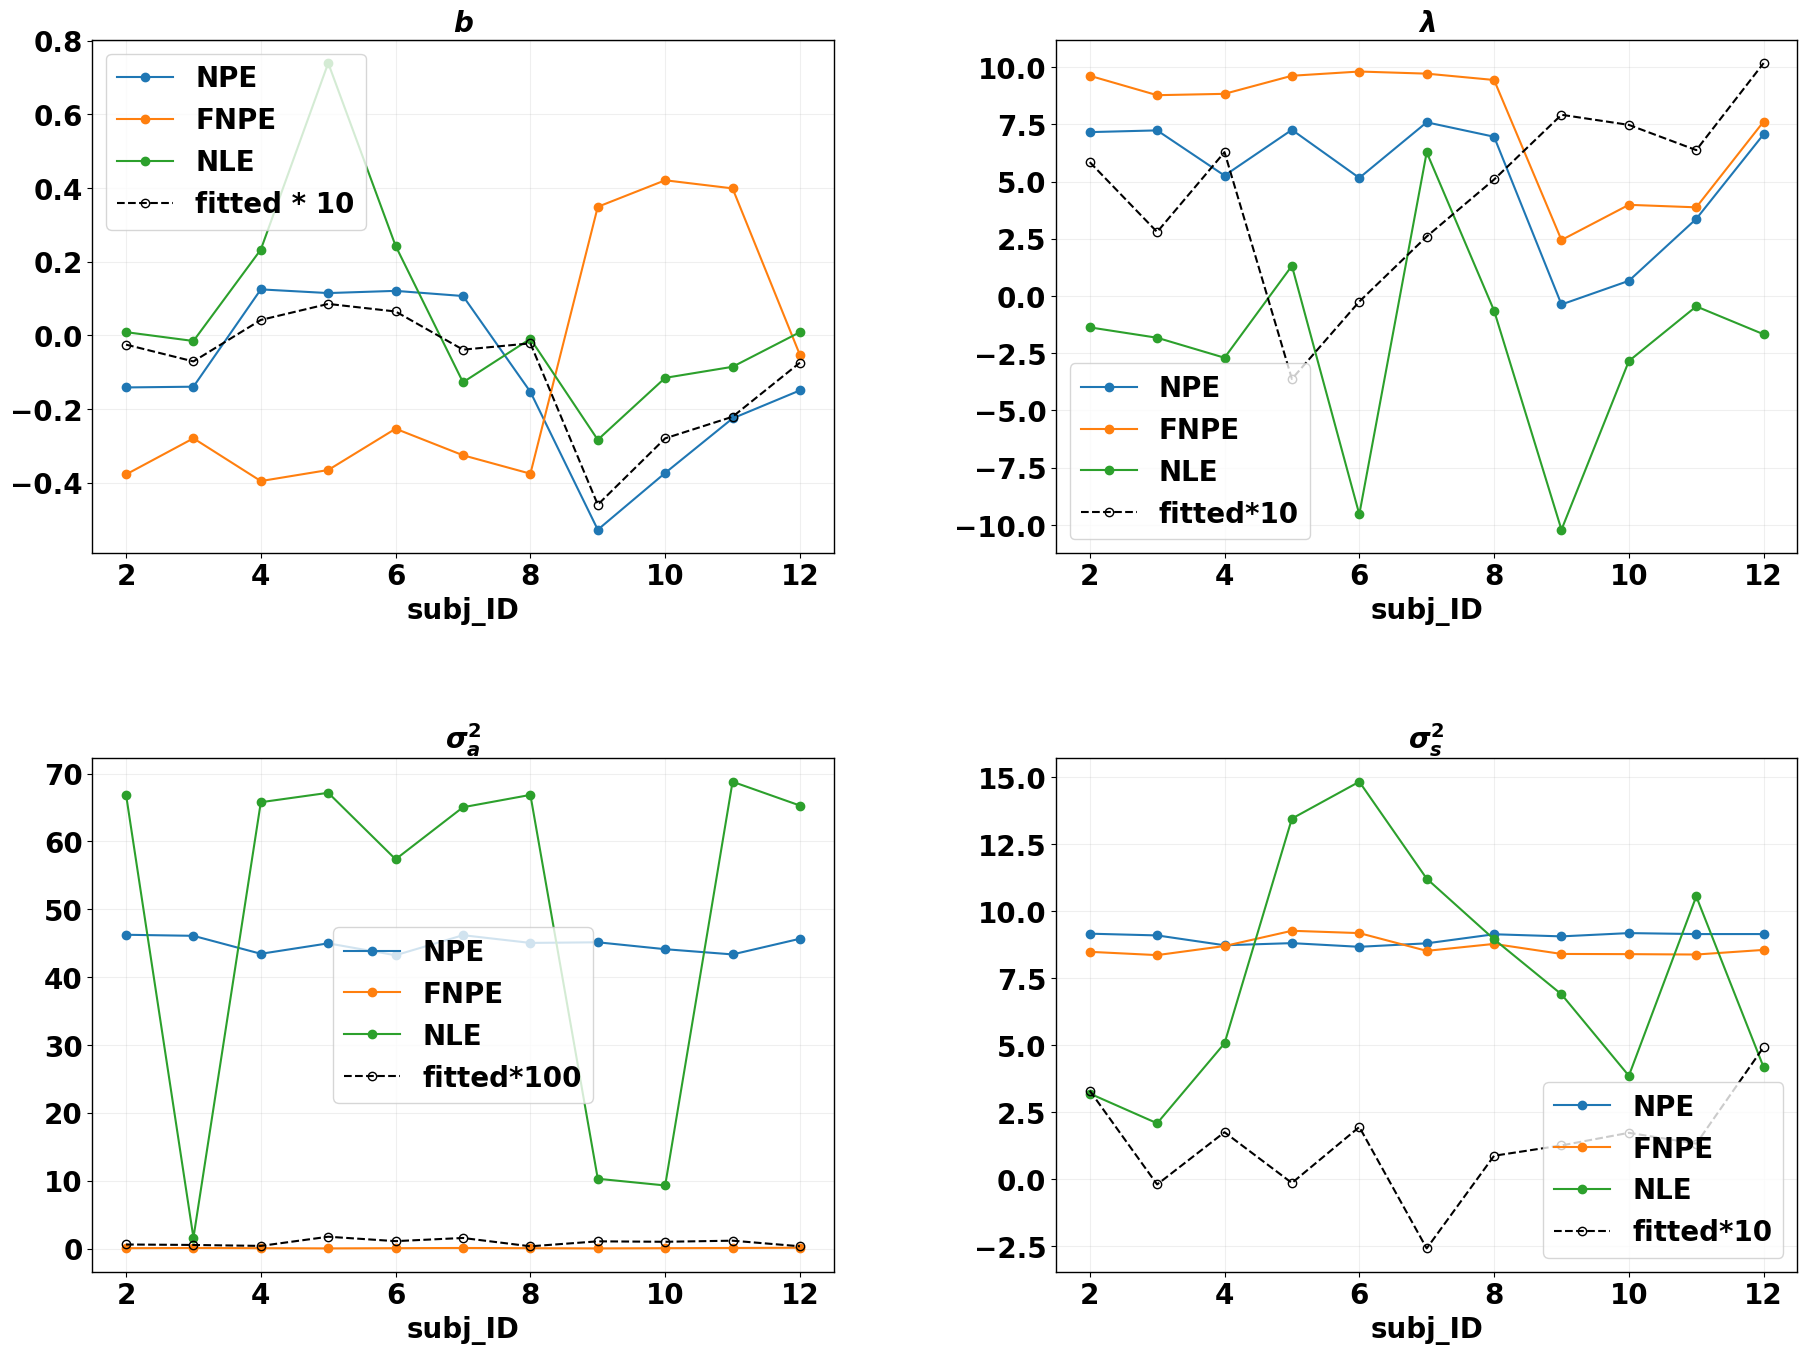

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(22, 16))
# vertical space
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = axes[0, 0]
for exp in exps[1:]:
    ax.plot(subj_IDs, bias_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, bias_fitted * 10, "ko--", label="fitted * 10", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("bias")
ax.set_title("$b$")
ax.grid(alpha=0.2)

ax = axes[0, 1]
for exp in exps[1:]:
    ax.plot(subj_IDs, L0_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, L0_fitted * 10, "ko--", label="fitted*10", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("L0")
ax.set_title("$\lambda$")
ax.grid(alpha=0.2)

ax = axes[1, 0]
for exp in exps[1:]:
    ax.plot(subj_IDs, sigma2a_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, sigma2a_fitted * 100, "ko--", label="fitted*100", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("sigma2a")
ax.set_title("$\sigma^2_a$")
ax.grid(alpha=0.2)

ax = axes[1, 1]
for exp in exps[1:]:
    ax.plot(subj_IDs, sigma2s_s[exps.index(exp)], "o-", label=exp)
ax.plot(subj_IDs, sigma2s_fitted * 10, "ko--", label="fitted*10", mfc="none")
ax.legend()
ax.set_xlabel("subj_ID")
# ax.set_ylabel("sigma2s")
ax.set_title("$\sigma^2_s$")
ax.grid(alpha=0.2)

fig_path = adapt_path("~/data/NSC/codes/notebook/pre-figure/subjects-inferences.png")
plt.savefig(fig_path, dpi=300)

In [125]:
subj_fitted, subj_NPE, subj_FNPE, subj_NLE

(array([[-0.00248543,  0.00605144,  0.33130382,  0.5848531 ],
        [-0.00704616,  0.00537454, -0.01865688,  0.27969743],
        [ 0.00421047,  0.00397233,  0.17624302,  0.62855791],
        [ 0.00856171,  0.01749028, -0.01303918, -0.36250575],
        [ 0.00650404,  0.01099397,  0.19575623, -0.02438316],
        [-0.00385137,  0.01566244, -0.25710309,  0.2598575 ],
        [-0.00214659,  0.0033858 ,  0.08845308,  0.50904154],
        [-0.04592312,  0.01070285,  0.12697161,  0.79172344],
        [-0.02792452,  0.01005825,  0.17406504,  0.74752502],
        [-0.0220616 ,  0.01166084,  0.13354055,  0.63733707],
        [-0.00736989,  0.00342664,  0.49401001,  1.01768512]]),
 array([[-0.14105642, 46.24929972,  9.16926771,  7.15966387],
        [-0.13905562, 46.0952381 ,  9.10444178,  7.23529412],
        [ 0.12505002, 43.44537815,  8.73709484,  5.2605042 ],
        [ 0.11504602, 44.9859944 ,  8.81632653,  7.2605042 ],
        [ 0.12104842, 43.22969188,  8.67947179,  5.15966387],
      

In [129]:
print(f"==>> subj_NPE.shape: {subj_NPE.shape}")

==>> subj_NPE.shape: (11, 4)


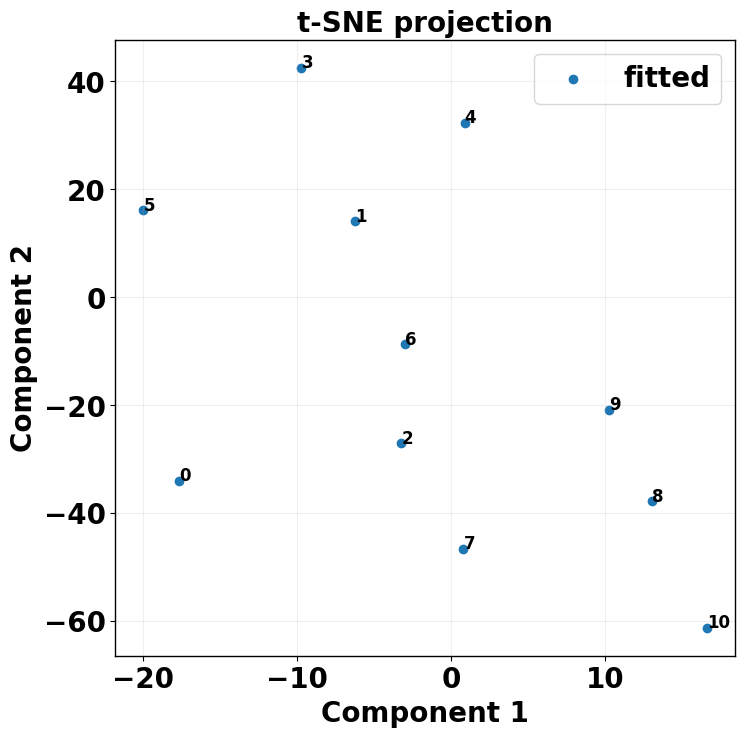

In [148]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Your (11, 4) array
subj_NPE = np.random.rand(11, 4)

# Initialize t-SNE model with a perplexity value less than 11
tsne = TSNE(n_components=2, perplexity=5, random_state=0)

# Perform t-SNE dimensionality reduction
proj_subj_NPE = tsne.fit_transform(subj_NPE)
proj_subj_FNPE = tsne.fit_transform(subj_FNPE)
proj_subj_NLE = tsne.fit_transform(subj_NLE)
proj_subj_fitted = tsne.fit_transform(subj_fitted)

fig, ax = plt.subplots(figsize=(8, 8))
# Plot the 2D projection
plt.scatter(proj_subj_fitted[:, 0], proj_subj_fitted[:, 1], label='fitted')

# Annotate each point
for i, txt in enumerate(range(proj_subj_fitted.shape[0])):
    plt.annotate(txt, (proj_subj_fitted[i, 0], proj_subj_fitted[i, 1]))

plt.title('t-SNE projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid()
plt.show()


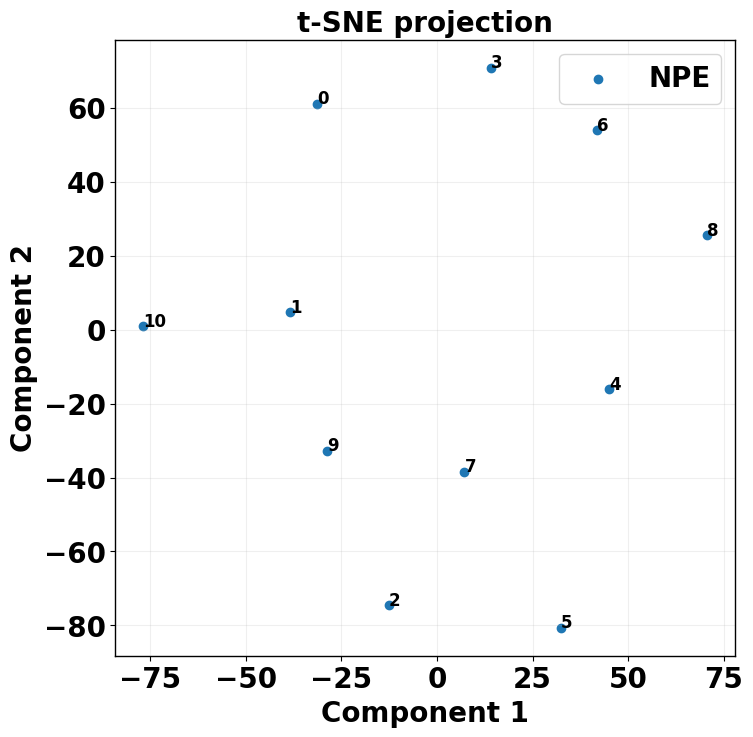

In [152]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Your (11, 4) array
subj_NPE = np.random.rand(11, 4)

# Initialize t-SNE model with a perplexity value less than 11

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
proj_subj_NPE = tsne.fit_transform(subj_NPE)
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
proj_subj_FNPE = tsne.fit_transform(subj_FNPE)
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
proj_subj_NLE = tsne.fit_transform(subj_NLE)
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
proj_subj_fitted = tsne.fit_transform(subj_fitted)

fig, ax = plt.subplots(figsize=(8, 8))
# Plot the 2D projection
plt.scatter(proj_subj_NPE[:, 0], proj_subj_NPE[:, 1], label='NPE')

# Annotate each point
for i, txt in enumerate(range(proj_subj_NPE.shape[0])):
    plt.annotate(txt, (proj_subj_NPE[i, 0], proj_subj_NPE[i, 1]))

plt.title('t-SNE projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid()
plt.show()


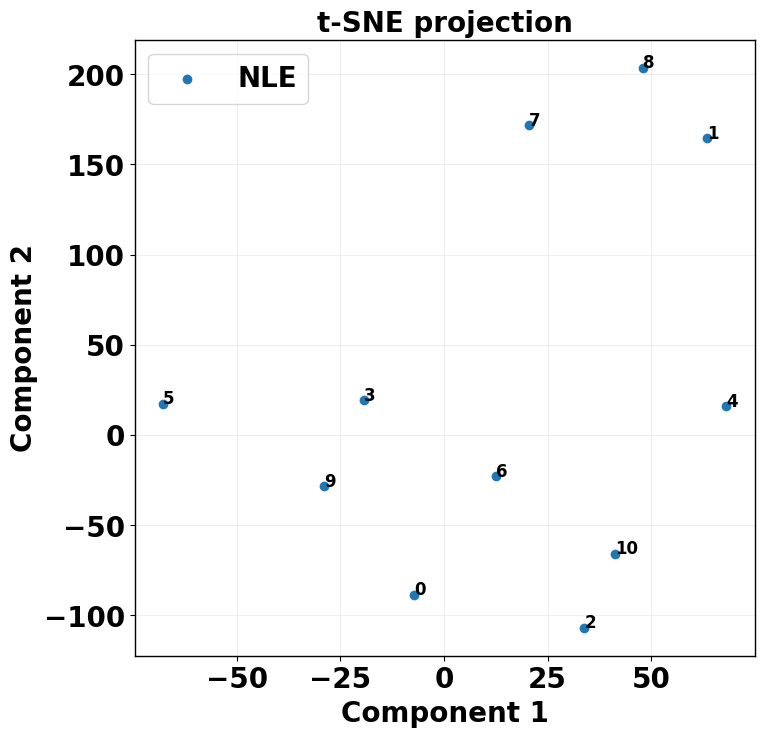

In [153]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot the 2D projection
plt.scatter(proj_subj_NLE[:, 0], proj_subj_NLE[:, 1], label='NLE')

# Annotate each point
for i, txt in enumerate(range(proj_subj_NLE.shape[0])):
    plt.annotate(txt, (proj_subj_NLE[i, 0], proj_subj_NLE[i, 1]))

plt.title('t-SNE projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid()
plt.show()


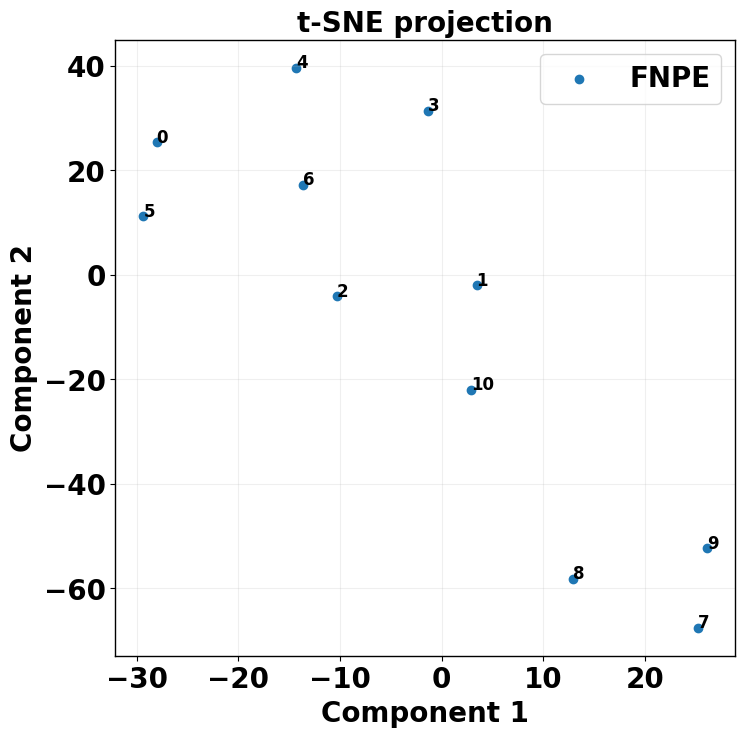

In [154]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot the 2D projection
plt.scatter(proj_subj_FNPE[:, 0], proj_subj_FNPE[:, 1], label='FNPE')

# Annotate each point
for i, txt in enumerate(range(proj_subj_FNPE.shape[0])):
    plt.annotate(txt, (proj_subj_FNPE[i, 0], proj_subj_FNPE[i, 1]))

plt.title('t-SNE projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid()
plt.show()